In [1]:
%load_ext autoreload
%autoreload 2
# Set-up: Import numpy and assign GPU
from collections import defaultdict
import os
import numpy as np
import scipy as sp
import seaborn as sns
import sklearn
from tqdm.notebook import tqdm

from gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('1')

Using GPU:1


In [3]:
# Load Amazon WILDS pre-trained model
import statistics
import sys
import pickle
import numpy as np
import pandas as pd

import torch
import torchvision.transforms as transforms

import argparse
import pdb

from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from transforms_helenl import initialize_transform, getBertTokenizer

sys.path.insert(0, './wilds/examples/')
os.environ["MODEL_DIR"] = '../model'

from algorithms.initializer import initialize_algorithm


In [4]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_seed(0)

In [5]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
#config_dict = pickle.load(open('amazon_config.txt', 'rb'))



full_dataset = get_dataset(dataset='civilcomments', download=False, root_dir = './wilds/data')

In [6]:
full_dataset.split_dict

{'train': 0, 'val': 1, 'test': 2}

In [ ]:
 # Grab config generated by WILDS library from txt file
    infile = open('civilcomments_config.txt','rb')
    new_dict = vars(pickle.load(infile))
    infile.close() 

    # Create config with ERM algorithm
    config = Namespace(**new_dict)

    new_dict

In [6]:
def predict_augmented_labels(transform_name):
    
    # Grab config generated by WILDS library from txt file
    infile = open('civilcomments_config.txt','rb')
    new_dict = vars(pickle.load(infile))
    infile.close() 

    # Modify config with intended transformation
    new_dict['transform'] = transform_name

    # Create config with ERM algorithm
    config = Namespace(**new_dict)
    config.algorithm = 'ERM'

    
    # Generate training and evaluation transforms
    train_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training=True)
    eval_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training=False)
    
    
    # Prepare training data, loader, and grouper
    train_data = full_dataset.get_subset('train', transform=train_transform)
    train_loader = get_train_loader('standard', train_data, batch_size=64)
    train_grouper = CombinatorialGrouper(dataset=full_dataset, groupby_fields=config.groupby_fields)
    
        # Prepare training data, loader, and grouper
        
    eval_data = full_dataset.get_subset('test', transform=eval_transform)
    eval_loader = get_eval_loader('standard', eval_data, batch_size = 64)
    
    # CODE TAKEN FROM WILDS TRAINING SCRIPTS:
    datasets = defaultdict(dict)
    for split in full_dataset.split_dict.keys():
        if split=='train':
            transform = train_transform
            verbose = True
        elif split == 'val':
            transform = eval_transform
            verbose = True
        else:
            transform = eval_transform
            verbose = False
        # Get subset
        datasets[split]['dataset'] = full_dataset.get_subset(
            split,
            frac=config.frac,
            transform=transform)

        if split == 'train':
            datasets[split]['loader'] = get_train_loader(
                loader=config.train_loader,
                dataset=datasets[split]['dataset'],
                batch_size=config.batch_size,
                uniform_over_groups=config.uniform_over_groups,
                grouper=train_grouper,
                distinct_groups=config.distinct_groups,
                n_groups_per_batch=config.n_groups_per_batch,
            **config.loader_kwargs)
        else:
            datasets[split]['loader'] = get_eval_loader(
                loader=config.eval_loader,
                dataset=datasets[split]['dataset'],
                grouper=train_grouper,
                batch_size=config.batch_size,
                **config.loader_kwargs)

    # Set fields
    datasets[split]['split'] = split
    datasets[split]['name'] = full_dataset.split_names[split]
    datasets[split]['verbose'] = verbose

    # Loggers
    # datasets[split]['eval_logger'] = BatchLogger(
    #     os.path.join(config.log_dir, f'{split}_eval.csv'), mode=mode, use_wandb=(config.use_wandb and verbose))
    # datasets[split]['algo_logger'] = BatchLogger(
    #     os.path.join(config.log_dir, f'{split}_algo.csv'), mode=mode, use_wandb=(config.use_wandb and verbose))

    print(transform_name)
    print("initialize model")
    # Initiate model and run on training set
    alg = initialize_algorithm(config, datasets, train_grouper)
    
    # TODO: pytorch load pretrained weights
    #alg.model.load_state_dict(torch.load('./best_model.pth'))
    alg.load_state_dict(torch.load('./best_model.pth')['algorithm'])
    alg.model.cuda()
    
    print("initialization complete")
    
    
    print("generating predictions")
    it = iter(eval_loader)
    predictions = []
    true_values = []
    
    for batch in tqdm(it):
        
        #pdb.set_trace()
        raw_pred = alg.model(batch[0].cuda()).cpu().detach().numpy().tolist()
        #softmax_prediction = sp.special.softmax(raw_pred.cpu().detach().numpy()).tolist()
        predictions.append(raw_pred)
        true_values.extend(batch[1].tolist())
    

    print("writing predictions")
    file_name = './ERM_predictions/' + transform_name + ".npy"
    
    with open(file_name, 'wb+') as file:
        np.save(file, predictions)
        np.save(file, true_values)



In [7]:
completed_augment_labels = [#'bert'
                           'nlp_ocr'
                           , 'nlp_keyboard'
                           , 'nlp_random_char_insert'
                           , 'nlp_random_char_substitution'
                           , 'nlp_random_char_swap'
                           , 'nlp_random_char_deletion'
                           , 'nlp_spelling_substitution'
                           ]


supported_augment_labels = ['nlp_random_similar_word_insertion_word2vec_embedding'
                           , 'nlp_random_similar_word_insertion_glove_embedding'
                           , 'nlp_random_similar_word_insertion_fasttext_embedding'
                           , 'nlp_random_similar_word_substitution_word2vec_embedding'
                           , 'nlp_random_similar_word_substitution_glove_embedding'
                           , 'nlp_random_similar_word_substitution_fasttext_embedding'
                           , 'nlp_random_similar_word_substitution_tfidf_embedding'
                           , 'nlp_random_contextual_word_insertion_bert_uncased_embedding'
                           , 'nlp_random_contextual_word_insertion_bert_cased_embedding'
                           , 'nlp_random_contextual_word_insertion_distilbert_uncased_embedding'
                           , 'nlp_random_contextual_word_insertion_distilbert_cased_embedding'
                           , 'nlp_random_contextual_word_insertion_roberta_base_embedding'
                           , 'nlp_random_contextual_word_insertion_distilroberta_base_embedding'
                           , 'nlp_random_contextual_word_insertion_xlnet_embedding'
                           , 'nlp_random_contextual_word_insertion_bart_base_embedding'
                           , 'nlp_random_contextual_word_insertion_squeezebert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_bert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_bert_cased_embedding'
                           , 'nlp_random_contextual_word_substitution_distilbert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_distilbert_cased_embedding'
                           , 'nlp_random_contextual_word_substitution_roberta_embedding'
                           , 'nlp_random_contextual_word_substitution_distilroberta_base_embedding'
                           , 'nlp_random_contextual_word_substitution_xlnet_embedding'
                           , 'nlp_random_contextual_word_substitution_bart_base_embedding'
                           , 'nlp_random_contextual_word_substitution_squeezebert_uncased_embedding'
                           , 'nlp_contextual_sentence_insertion_gpt2_embedding'
                           , 'nlp_contextual_sentence_insertion_xlnet_cased_embedding'
                           , 'nlp_contextual_sentence_insertion_distilgpt2_embedding'
                           , 'nlp_abstractive_summarization_bart_large_cnn'
                           , 'nlp_abstractive_summarization_t5_small'
                           , 'nlp_abstractive_summarization_t5_base'
                           , 'nlp_abstractive_summarization_t5_large'
                           , 'nlp_wordnet_synonym'
                           , 'nlp_ppdb_synonym'
                           , 'nlp_antonym'
                           , 'nlp_random_word_swap'
                           , 'nlp_random_word_delete'
                           , 'nlp_random_crop'
                           , 'nlp_random_token_split'
                           , 'nlp_back_translation_aug'
                           ]

In [8]:
def calculate_accuracy(prediction_file):
    logit_predictions = []
    labels = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file, allow_pickle = True)
        labels = np.load(file, allow_pickle = True)
    
    '''
    softmaxed_predictions = []
    
    for pred in logit_predictions[0]:
        softmax = sp.special.softmax(pred).tolist()
        softmaxed_predictions.append(softmax[1])
        
    #plt.hist(logit_predictions)
    #plt.hist(softmaxed_predictions)
    
    #return sklearn.metrics.roc_auc_score(labels[:64], softmaxed_predictions)
    '''
    classified_predictions = []
    for prediction in logit_predictions:
        index_prediction = np.argmax(prediction, axis = 1).tolist()
        
        classified_predictions.extend(index_prediction)
    
    '''
    unique, counts = np.unique(np.array(classified_predictions), return_counts = True)
    print(unique, counts)
    print(len(labels))
    '''
    
    score = sklearn.metrics.accuracy_score(labels, classified_predictions)
    return score

In [16]:
def calculate_recall(prediction_file):
    logit_predictions = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file)
        true_values = np.load(file)
        
    print(true_values)
    classified_predictions = []
    for prediction in logit_predictions:
        if prediction[0][0] > prediction[0][1]:
            classified_predictions.append(0)
            
        else:
            classified_predictions.append(1)
    
    score = sklearn.metrics.recall_score(true_values, classified_predictions)
    return score

In [9]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)


"""
Create graph comparing accuracy of all supported augmentations

Parameters:
    augmentations: list of strings, each corresponding to a supported augmentation
    
"""

def create_accuracy_graph(augmentations):
    
    aug_to_acc = []
    for augmentation in augmentations:
        file_name = './ERM_predictions/' + augmentation + ".npy"
        accuracy = calculate_accuracy(file_name)
        
        aug_dict = {"augmentation":augmentation, "accuracy": accuracy}
        aug_to_acc.append(aug_dict)

    
    acc_df = pd.DataFrame(aug_to_acc).sort_values('accuracy', ascending = False)
    print(acc_df)
    
    sns.set(rc = {'figure.figsize':(30,10)})
    p = sns.barplot(x = 'augmentation', y = 'accuracy', data = acc_df, ci = None)#, order = acc_df['augmentation'])
    show_values(p)

"""
Create graph comparing accuracy of all supported augmentations

Parameters:
    augmentations: list of strings, each corresponding to a supported augmentation
    
"""

def create_augmentation_impact_graph(augmentations):
    aug_to_mean_acc = []
    
    original_accuracy = calculate_accuracy('./ERM_predictions/bert.npy').item()

    for augmentation in augmentations:
        file_name = './ERM_predictions/' + augmentation + ".npy"
        augmentation_accuracy = calculate_accuracy(file_name).item()
        
        mean_accuracy = (augmentation_accuracy + original_accuracy) / 2
    

        augmentation_name = augmentation[4:] + "+bert" # remove 'nlp_' prefix in augmentation name
        
        aug_dict = {"augmentation":augmentation_name, "accuracy": mean_accuracy}
        aug_to_mean_acc.append(aug_dict)
    
    acc_df = pd.DataFrame(aug_to_mean_acc).sort_values('accuracy', ascending = False)
    print(acc_df)
    
    sns.set(rc = {'figure.figsize':(30,10)})
    p = sns.barplot(x = 'augmentation', y = 'accuracy', data = acc_df, ci = None)
    show_values(p)
    #ax.figure.set_size_inches(200,10)
    
    
    

In [86]:
predict_augmented_labels('bert')

{'dataset': 'civilcomments', 'algorithm': 'ERM', 'root_dir': 'data', 'split_scheme': 'official', 'dataset_kwargs': {}, 'download': False, 'frac': 1.0, 'version': None, 'loader_kwargs': {'num_workers': 1, 'pin_memory': True}, 'train_loader': 'standard', 'uniform_over_groups': False, 'distinct_groups': None, 'n_groups_per_batch': 4, 'batch_size': 16, 'eval_loader': 'standard', 'model': 'distilbert-base-uncased', 'model_kwargs': {}, 'transform': 'bert', 'target_resolution': None, 'resize_scale': None, 'max_token_length': 300, 'loss_function': 'cross_entropy', 'loss_kwargs': {}, 'groupby_fields': ['black', 'y'], 'group_dro_step_size': None, 'coral_penalty_weight': 10.0, 'irm_lambda': 1.0, 'irm_penalty_anneal_iters': None, 'algo_log_metric': 'accuracy', 'val_metric': 'acc_wg', 'val_metric_decreasing': False, 'n_epochs': 5, 'optimizer': 'AdamW', 'lr': 1e-05, 'weight_decay': 0.01, 'max_grad_norm': 1.0, 'optimizer_kwargs': {}, 'scheduler': 'linear_schedule_with_warmup', 'scheduler_kwargs': {'n

In [10]:
for augment in supported_augment_labels:
    predict_augmented_labels(augment)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

nlp_random_similar_word_insertion_word2vec_embedding
initialize model


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertClassifier: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN t

initialization complete
generating predictions


  0%|          | 0/2091 [00:00<?, ?it/s]

NameError: name 'model_dir' is not defined

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline

calculate_accuracy('./ERM_predictions/nlp_ocr.npy')

0.3795454545454546

In [19]:
calculate_accuracy('./ERM_predictions/bert.npy')

[0 1] [120992  12790]
133782
PREDICTIONS: 133782
TRUE VALUES: 133782


0.9266418501741639

In [20]:
supported_augment_labels = ['bert'
                           , 'nlp_ocr'
                           , 'nlp_keyboard'
                           , 'nlp_random_char_insert'
                           , 'nlp_random_char_substitution'
                           , 'nlp_random_char_swap'
                           , 'nlp_random_char_deletion'
                           , 'nlp_spelling_substitution'
                           , 'nlp_random_word_swap'
                           , 'nlp_random_word_delete'
                           #, 'nlp_random_crop'
                           #, 'nlp_random_token_split'
                           #, 'nlp_back_translation_aug'
                           ]

                   augmentation  accuracy
0                          bert  0.926642
8          nlp_random_word_swap  0.926059
7     nlp_spelling_substitution  0.920243
1                       nlp_ocr  0.919444
9        nlp_random_word_delete  0.917044
6      nlp_random_char_deletion  0.911303
5          nlp_random_char_swap  0.910803
4  nlp_random_char_substitution  0.910556
3        nlp_random_char_insert  0.910541
2                  nlp_keyboard  0.909951


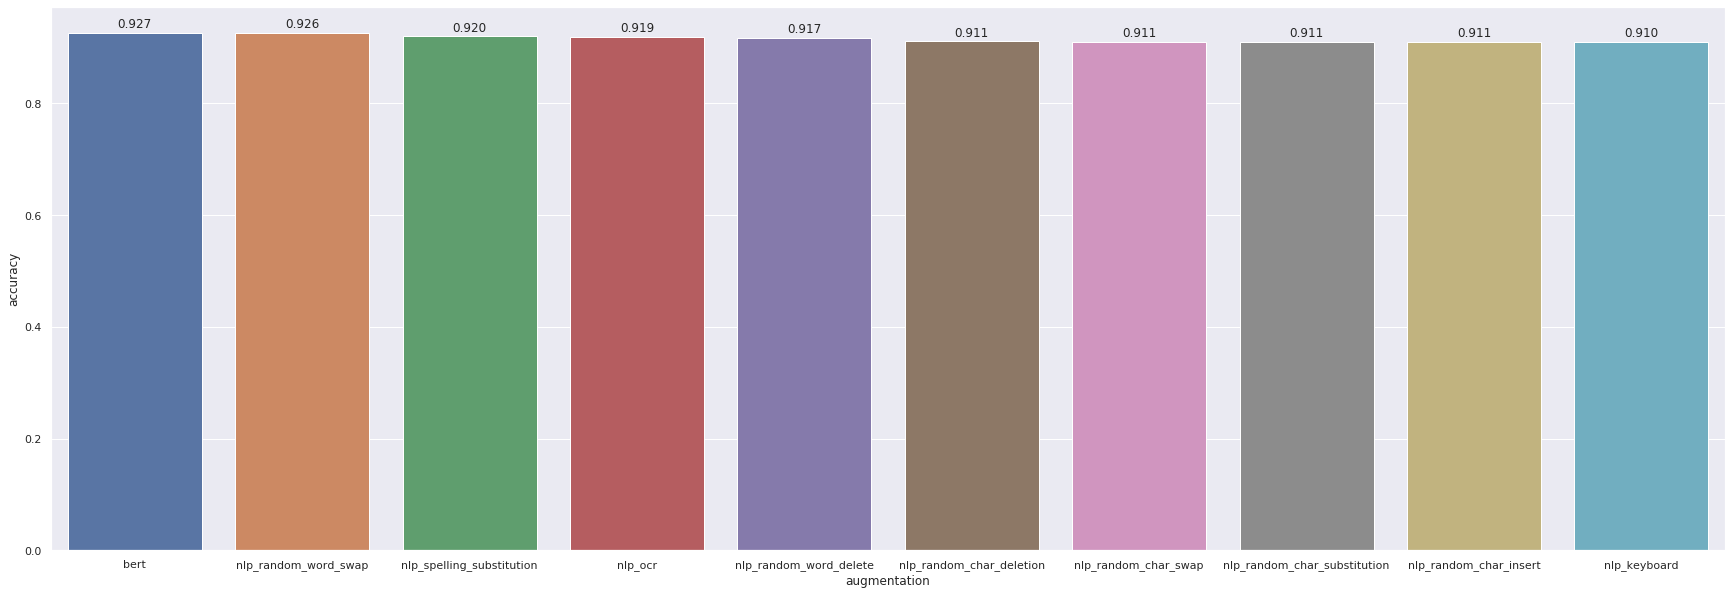

In [73]:
create_accuracy_graph(supported_augment_labels)
#create_accuracy_graph(['bert'])

                    augmentation  accuracy
0                          +bert  0.926642
8          random_word_swap+bert  0.926350
7     spelling_substitution+bert  0.923443
1                       ocr+bert  0.923043
9        random_word_delete+bert  0.921843
6      random_char_deletion+bert  0.918973
5          random_char_swap+bert  0.918722
4  random_char_substitution+bert  0.918599
3        random_char_insert+bert  0.918591
2                  keyboard+bert  0.918296


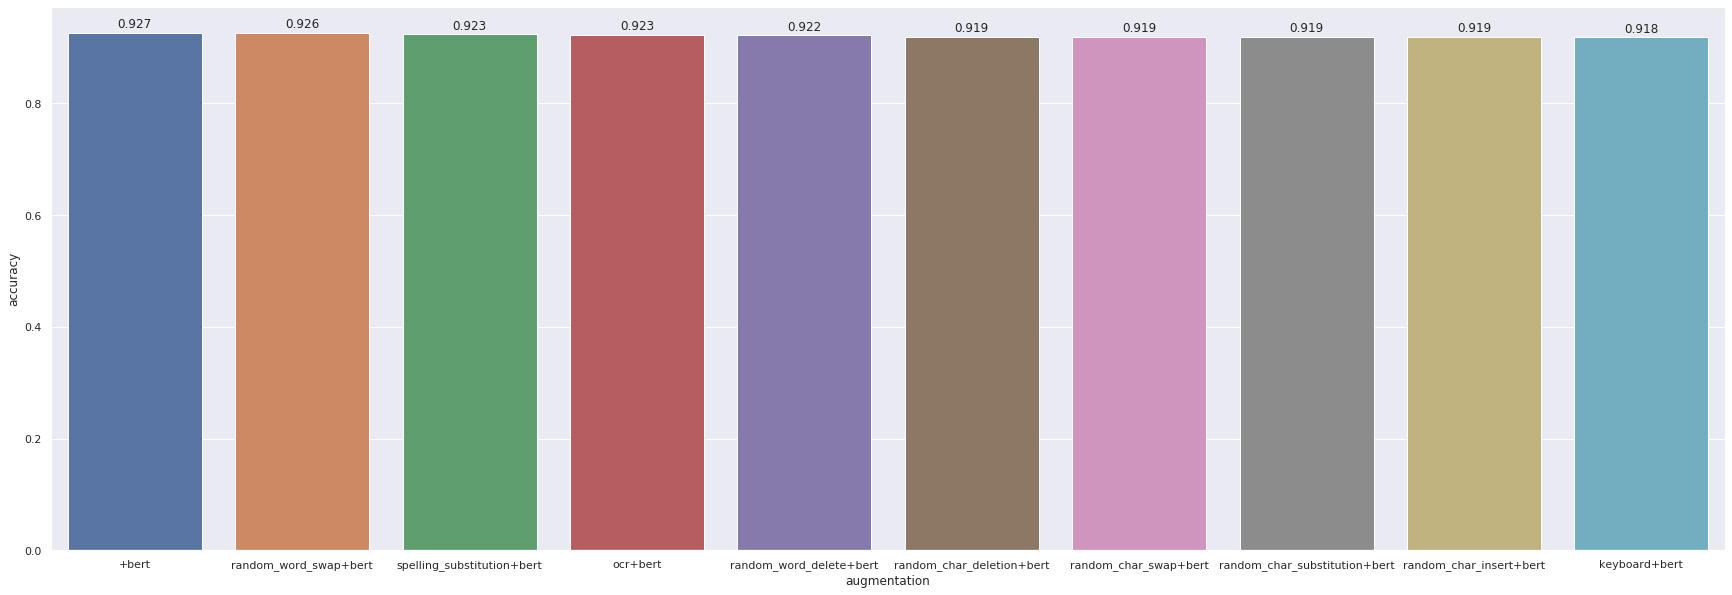

In [74]:
create_augmentation_impact_graph(supported_augment_labels)

In [ ]:
# PLOT: corruptions vs. corrections
# subsample 80% to create error bars -> add more rows for each run to generate error bars

# Modify parameter of how many modifications there are (1 word, 2 words)
    # x is intensity of augmentation, y is accuracy
    # For a specific augmentation, how does average response change (higher intensity + original)

    
# x-axis: number of draws, y-axis: average performance across draws
    # Up to 20 or 50 draws of words to delete/characters to augment
    # up to 50 for words, 100 for char
     
# TFIDF 33 hours RT: check gpustat; is implementation necessary for our experiments?
# Report group-specific accuracy (identities; detecting hate-speech towards specific groups)
    # Similar corruptions vs. corrections
    # See WILDS documentation for metadata
    # Make one for each augmentation (x axis identity group, y axis performance)
    

In [52]:
with open('nlp_ocr_ERM_predictions.npy', 'rb') as g:#, open('nlp_random_char_insert_ERM_predictions.npy', 'rb') as h:
    a = np.load(g)
    #b = np.load(g)
    #c = np.load(h)
    
print(a)#, b, c)

[[0.45754883 0.54245126]]


In [ ]:
train_data[1]

In [15]:
len(batch[1])
batch[1]
#batch[2]

# batch[0] is array of input features
# batch[1] is array of labels
# batch[2] is array of metadata

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [25]:
np.shape(batch[0][0])

torch.Size([300, 2])

In [30]:
np.shape(batch[0][0])

np.shape(torch.unsqueeze(batch[0][0], 0))

torch.Size([1, 300, 2])

In [13]:
x = model.model(torch.unsqueeze(batch[0][0], 0).cuda())

# Outputting before transforming to measure toxicity

# Apply softmax to normalize and sum to 1

# Save predictions while iterating through samples into .npy or pickl (np.save)

In [33]:
softmax_prediction = sp.special.softmax(x.cpu().detach().numpy())
softmax_prediction.tolist()



[[0.4568701684474945, 0.5431299209594727]]

In [32]:
datasets[split]

{'dataset': <wilds.datasets.wilds_dataset.WILDSSubset at 0x7fa531852a58>,
 'loader': <torch.utils.data.dataloader.DataLoader at 0x7fa531852a90>,
 'split': 'test',
 'name': 'Test',
 'verbose': False}

In [33]:
datasets['val']['loader']